In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'cotton_disease/train'
valid_path = 'cotton_disease/test'

In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [6]:
# useful for getting number of output classes
folders = glob('cotton_disease/train/*')

In [7]:
len(folders)

4

In [8]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('cotton_disease/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [14]:
test_set = test_datagen.flow_from_directory('cotton_disease/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\anura\AppData\Local\Temp\ipykernel_14056\4130870686.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
61/61 [==============================] - 344s 6s/step - loss: 3.1501 - accuracy: 0.3998 - val_loss: 1.2872 - val_accuracy: 0.6111
Epoch 2/20
61/61 [==============================] - 288s 5s/step - loss: 0.9718 - accuracy: 0.6176 - val_loss: 0.8839 - val_accuracy: 0.7222
Epoch 3/20
61/61 [==============================] - 241s 4s/step - loss: 0.9882 - accuracy: 0.6089 - val_loss: 1.0280 - val_accuracy: 0.7778
Epoch 4/20
61/61 [==============================] - 241s 4s/step - loss: 0.9060 - accuracy: 0.6299 - val_loss: 0.9828 - val_accuracy: 0.6111
Epoch 5/20
61/61 [==============================] - 241s 4s/step - loss: 1.1117 - accuracy: 0.5997 - val_loss: 1.5446 - val_accuracy: 0.6111
Epoch 6/20
61/61 [==============================] - 241s 4s/step - loss: 0.8676 - accuracy: 0.6797 - val_loss: 0.6601 - val_accuracy: 0.6667
Epoch 7/20
61/61 [==============================] - 241s 4s/step - loss: 0.7119 - accuracy: 0.7114 - val_loss: 0.6005 - val_accuracy: 0.7222
Epoch 8/20
61

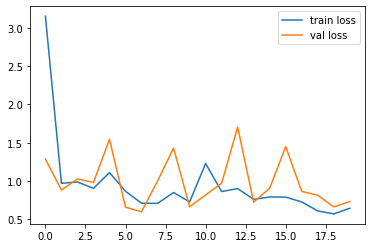

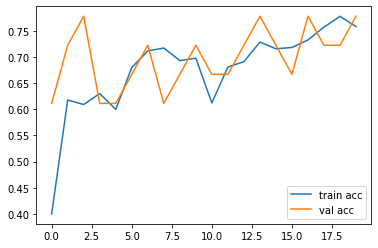

<Figure size 432x288 with 0 Axes>

In [16]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [17]:
# save it as a h5 file

from tensorflow.keras.models import load_model
model.save('model_resnet50.h5')

In [18]:
y_pred = model.predict(test_set)

In [19]:
y_pred

array([[2.09195437e-04, 6.46046281e-01, 1.05435938e-04, 3.53639066e-01],
       [1.26256185e-04, 5.14076208e-04, 9.89104152e-01, 1.02554467e-02],
       [6.18870399e-05, 4.97547984e-02, 7.03667104e-03, 9.43146586e-01],
       [1.17932864e-01, 4.14459139e-01, 1.49694635e-02, 4.52638537e-01],
       [1.61279444e-04, 3.29901278e-03, 6.55304734e-03, 9.89986598e-01],
       [3.23498462e-05, 2.12349929e-02, 1.25531689e-03, 9.77477372e-01],
       [2.02641750e-04, 8.44783306e-01, 2.16756966e-02, 1.33338332e-01],
       [3.39784718e-04, 9.35470045e-01, 1.14705072e-04, 6.40753582e-02],
       [2.98037572e-04, 5.74050367e-01, 1.82480495e-02, 4.07403648e-01],
       [9.80453372e-01, 1.07392611e-06, 9.20270104e-03, 1.03428392e-02],
       [2.37821601e-04, 2.00378963e-06, 9.99738395e-01, 2.17697434e-05],
       [4.94981278e-03, 5.54256558e-01, 1.58082008e-01, 2.82711536e-01],
       [2.46415948e-06, 4.91437959e-07, 9.99186099e-01, 8.10846803e-04],
       [1.01451215e-03, 3.36218765e-03, 9.59213197e